Not

In [1]:
#standard libraries
import warnings
warnings.filterwarnings('ignore')
import os
import time
import numpy as np
import pandas as pd

from gensim.corpora import Dictionary
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser

import seaborn as sns
import matplotlib.pyplot as plt

#### Version 1 - Topic Modeling for three Tier 1 cities in India - Delhi, Mumbai, Bangalore

In [2]:
# reading in relevant data frames
#version 1
del_df = pd.read_pickle("data/del_df.pkl")
mum_df = pd.read_pickle("data/mum_df.pkl")
ban_df = pd.read_pickle("data/ban_df.pkl")

In [3]:
del_df.sample(2)

,text,processed_text,bigrams,processed_text_bigrams
10176,"Oh my fucking god, baat ye hai, mere saath bhi...","[fucking, baat, mere, saath, fucking, weird, t...","[fucking, baat, mere_saath, fucking, weird, ti...","[fucking, baat, mere, saath, fucking, weird, t..."
42547,Sab jante ho na bhai aap 🫣🫠,"[jante, bhai]","[jante, bhai]","[jante, bhai]"


In [5]:
def topic_coherence(tokens, num_topics, return_coh = True):
    """this function created a gensim LDA topic model for the given number of topics and then calculates the overall coherence
    score for each model"""
    
    #create a dictionary (a list of all the tokens)
    dictionary = Dictionary(tokens.values)
    dictionary.filter_extremes(no_below=10, no_above=0.9)
    
    # use the dictionary to create a bag of word representation of each document
    corpus = [dictionary.doc2bow(token) for token in tokens.values]
    
    lda_model = LdaModel(corpus = corpus, id2word = dictionary, num_topics = num_topics, random_state = 42)
    topic_words = lda_model.top_topics(corpus, coherence = 'c_v', texts = tokens.values, topn = 20) #top 20 words

    if return_coh:
        avg_coherence = 0
        for i in range(0, num_topics): 
            avg_coherence += topic_words[i][-1]
        avg_coherence = round(avg_coherence/num_topics,2)
        return topic_words, avg_coherence

    else: 
        return topic_words

In [6]:
def optimal_topics(df):
    """this function helps determine the optimal number of topics for a given dataset based on the coherence score"""
    
    num_of_topics = range(2, 11, 1) #considering between 2 and 10 topics
    avg_coherence = []
    for i in num_of_topics:
        # avg_coherence.append(topic_coherence(df["processed_text"], i)[-1])
        avg_coherence.append(topic_coherence(df["processed_text_bigrams"], i)[-1])
                         
    return avg_coherence

In [8]:
top_coh_in = pd.DataFrame(index = range(2,11,1))
top_coh_in["delhi"] = optimal_topics(del_df)
top_coh_in["mumbai"] = optimal_topics(mum_df)
top_coh_in["bangalore"] = optimal_topics(ban_df)
top_coh_in

,delhi,mumbai,bangalore
2,0.80,0.66,0.74
3,0.74,0.62,0.72
4,0.63,0.67,0.71
5,0.66,0.63,0.72
6,0.65,0.63,0.68
7,0.65,0.60,0.68
8,0.59,0.58,0.67
9,0.63,0.59,0.69
10,0.56,0.56,0.65


In [10]:
def plot_coherence(top_coh):
    """simple plot showing topic vs coherence for each dataset"""
    plt.figure(figsize = (5, 4));

    for col in top_coh.columns:
        sns.lineplot(top_coh[col], markers = True, label = str(col)); 

    plt.gca().set_xticks(range(1, 11));
    plt.gca().set_xlabel("Topics");
    # plt.gca().set_yticks(np.arange(.55, .9, 0.05));
    plt.gca().set_ylabel("Coherence Scores");
    plt.legend();
    plt.title("Coherence Scores by Number of Topics for each Dataset", fontsize = 10);
    
    return plt

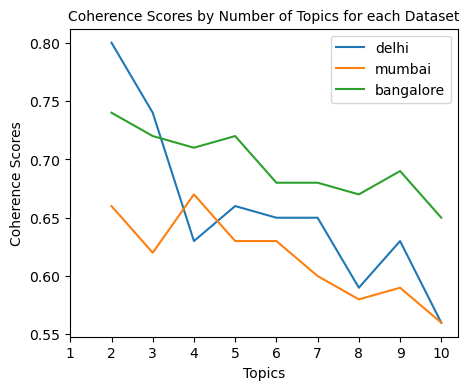

In [13]:
os.chdir('/home/prabhur/reddit_project/')
plt = plot_coherence(top_coh_in)
plt.savefig("images/TopvsCoherence_India.jpg")

In [44]:
def plot_topic_word_heatmap(topics, subreddit, fig_size, num_topics = 2, num_words = 20):
    fig = plt.figure(figsize = fig_size)
    score = []
    word = []
    topic = []
    coh = 0
    for i in range(num_topics):     #for each topic
        coh += topics[i][-1] 
        for j in range(num_words):
            score.append(round(topics[i][0][j][0], 4))
            word.append(topics[i][0][j][1])
            topic.append(f"""Topic {str(i+1)}""")

    _ = pd.DataFrame({"Topics": topic, "word" : word, "score" : score})
    _.sort_values(["Topics", "score"], ascending = [True, False], inplace = True)
    _["rank"] = list(np.arange(0, num_words).astype(str)) * num_topics
    _p = _.pivot_table("score", "Topics", "rank", sort =False)

    # Create an array to annotate the heatmap
    topic_labels = list(_.Topics.unique())
    annot_labels = np.asarray([f"""{word} 
{str(score)}""" for word, score in zip(_.word.values.flatten(),_.score.values.flatten())]
                        ).reshape(num_topics, num_words)
    ax = sns.heatmap(_p, cmap = "YlGnBu", fmt="", annot = annot_labels, annot_kws={"fontsize":9},
                         yticklabels = topic_labels, xticklabels = False);
    ax.set(xlabel="");
    ax.set_title(f"Topic Modeling Analysis for r/{subreddit} \n Overall Model Coherence: {round(coh/num_topics, 4)}");
    return plt
    
    return

##### Selecting topics based on coherence scores
Based on the coherence score plot above, it appears that a two topic model would be ideal

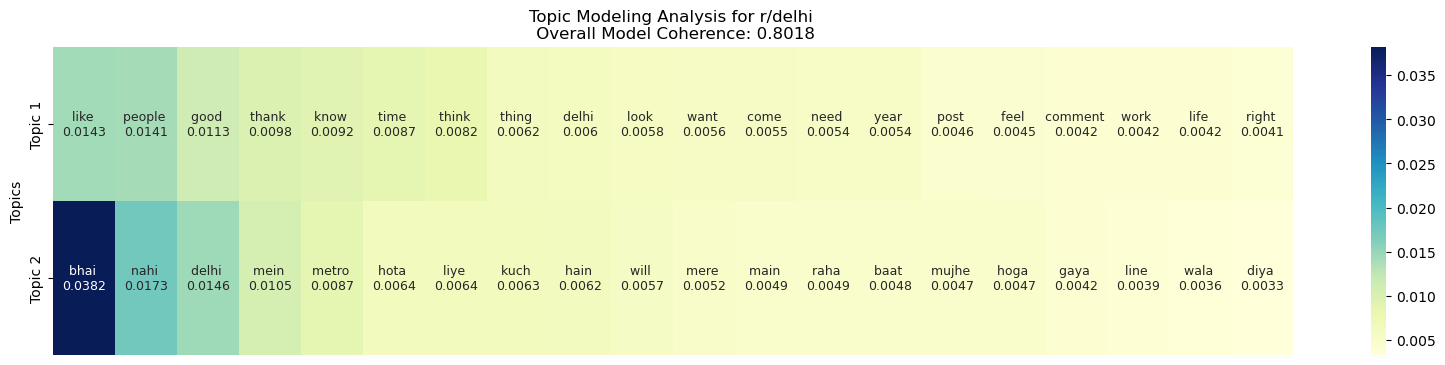

In [45]:
del_two_topics = topic_coherence(del_df["processed_text_bigrams"], 2, return_coh = False)
plt = plot_topic_word_heatmap(del_two_topics, "delhi", (20,4))
plt.savefig("images/delhi_top2_topics_words_per_topic.png")

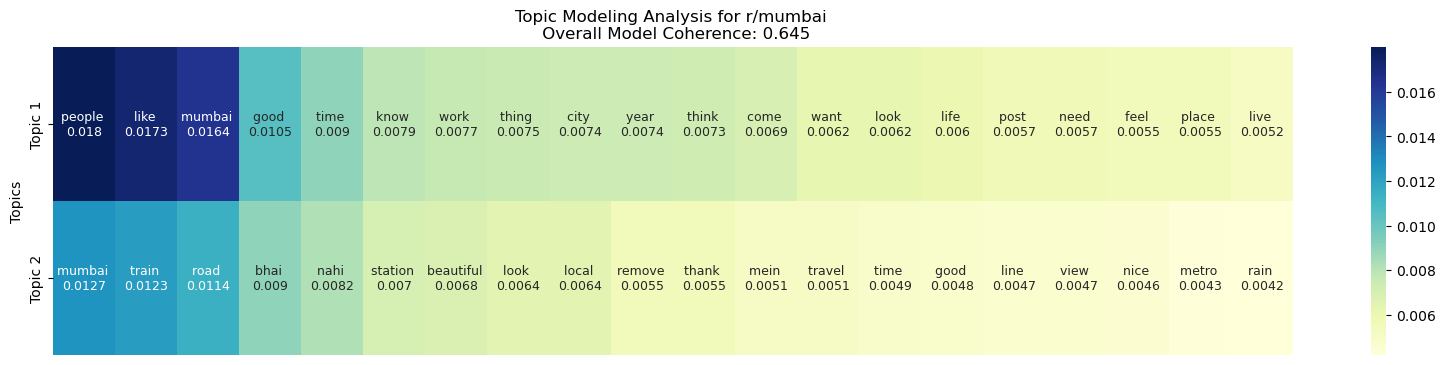

In [47]:
mum_two_topics = topic_coherence(mum_df["processed_text"], 2, return_coh = False)
plt = plot_topic_word_heatmap(mum_two_topics, "mumbai", (20,4), 2)
plt.savefig("images/mumbai_top2_topics_words_per_topic.png")

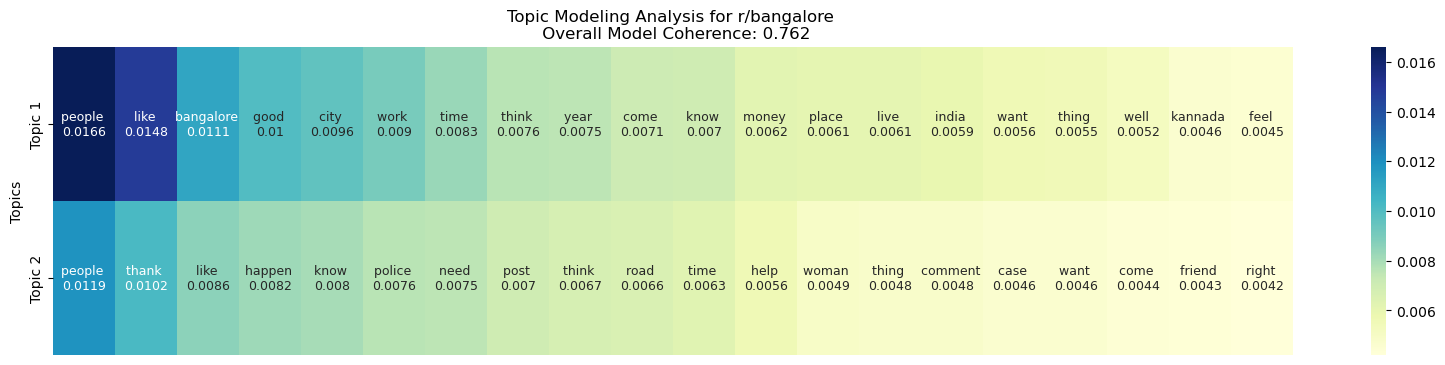

In [48]:
ban_two_topics = topic_coherence(ban_df["processed_text"], 2, return_coh = False)
plt = plot_topic_word_heatmap(ban_two_topics, "bangalore", (20,4), 2)
plt.savefig("images/bangalore_top2_topics_words_per_topic.png")

##### Top 5 topics

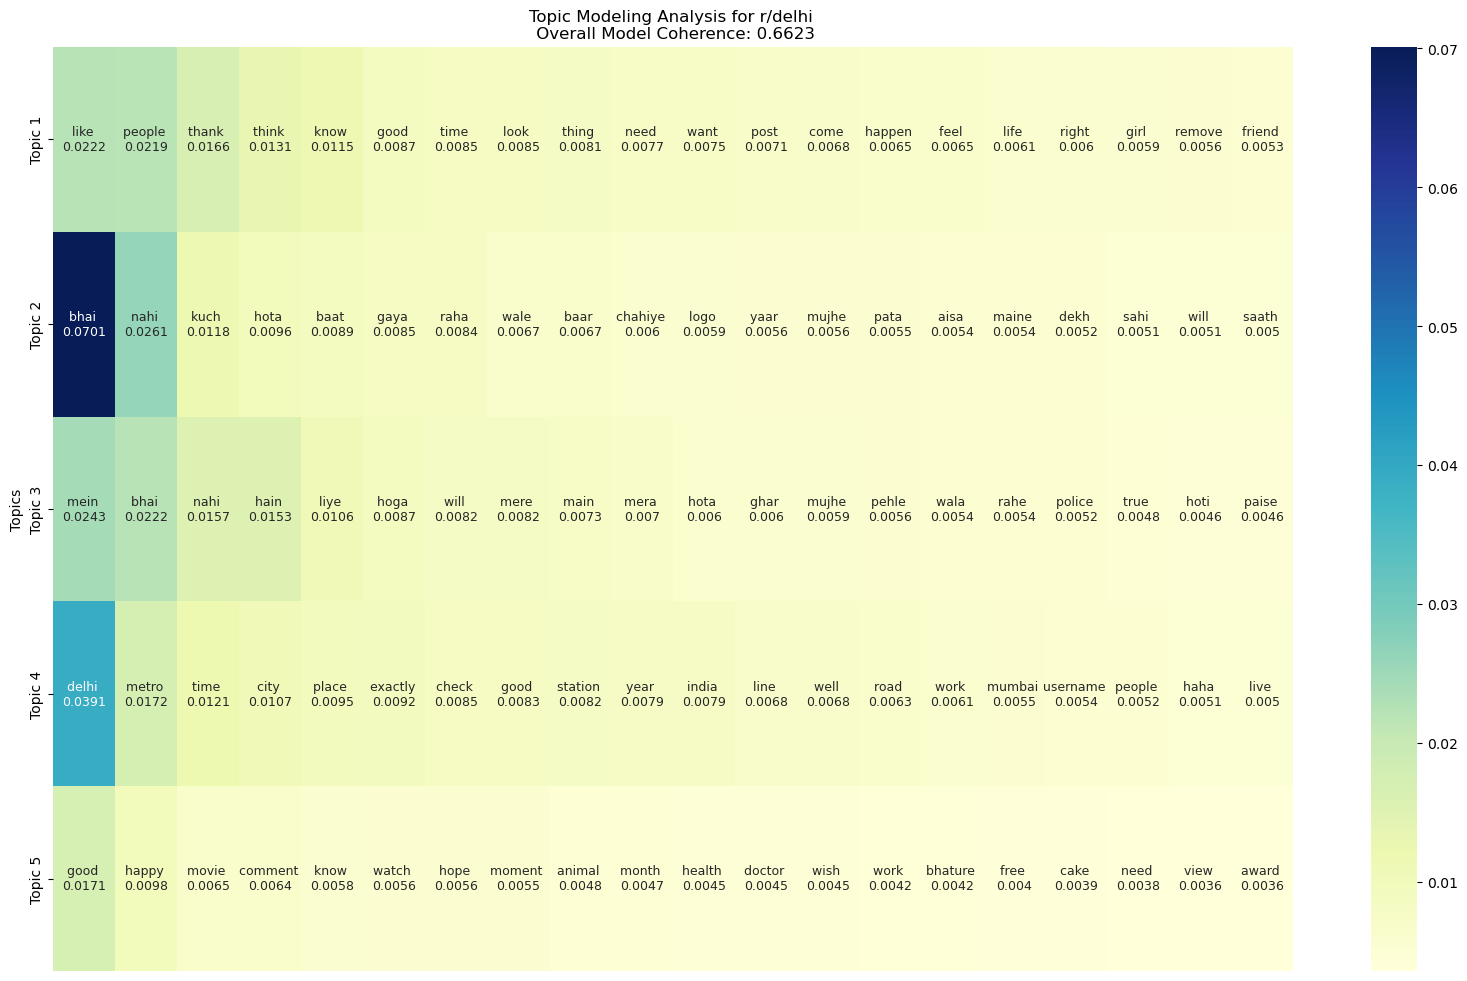

In [49]:
del_top5_topics = topic_coherence(del_df["processed_text_bigrams"], 5, return_coh = False)
plt = plot_topic_word_heatmap(del_top5_topics, "delhi", (20,12), 5)
plt.savefig("images/delhi_top5_topics_words_per_topic.png")

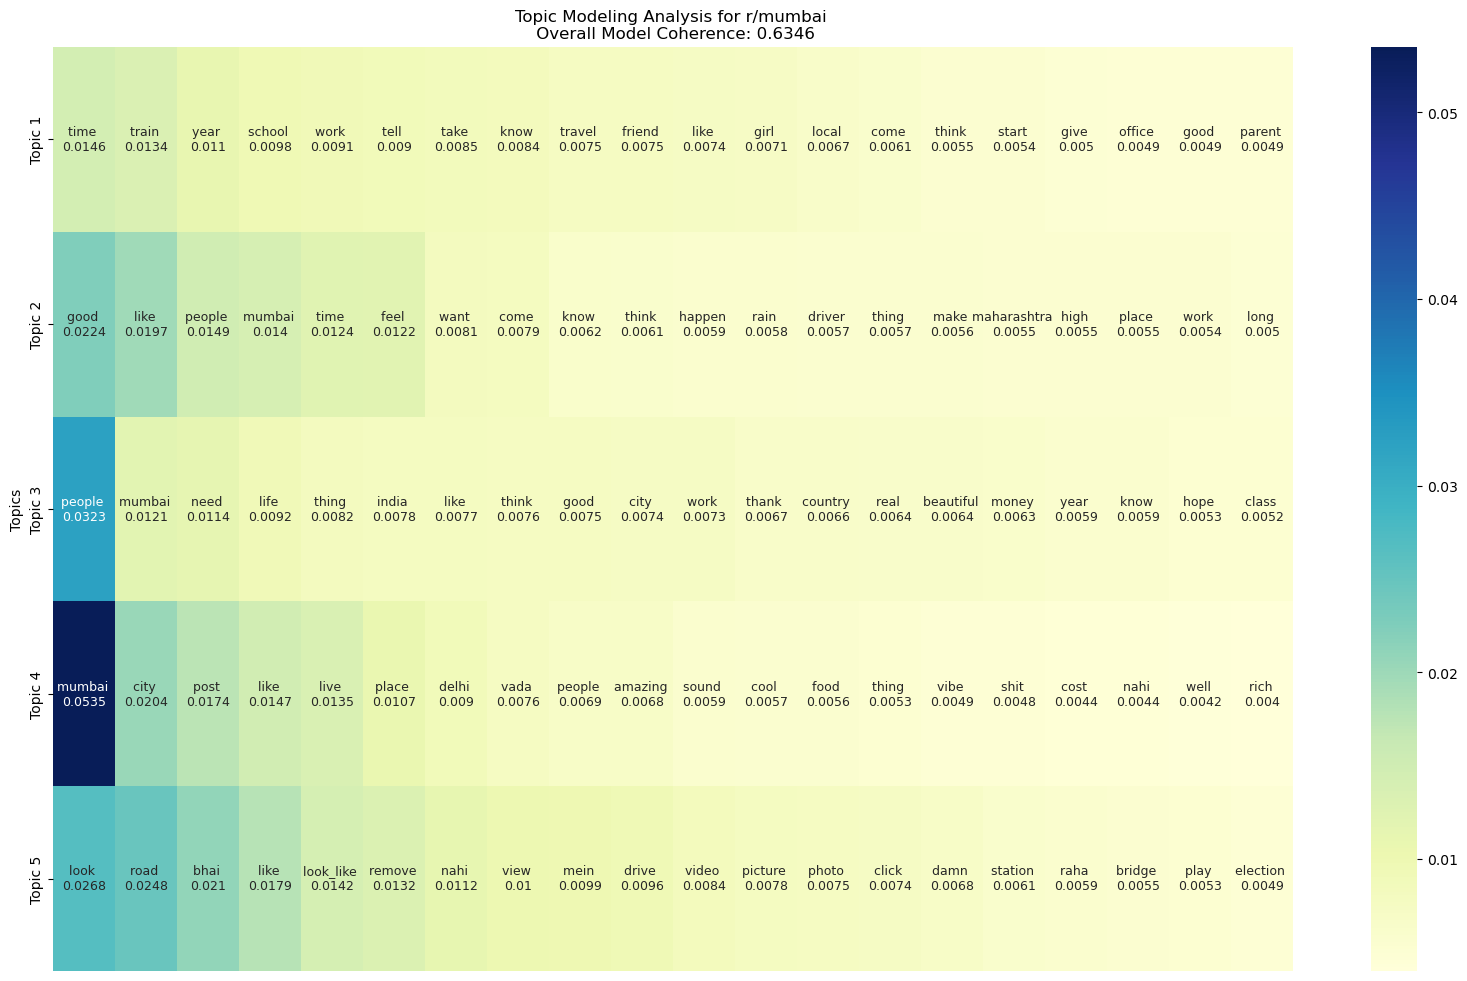

In [50]:
mum_top5_topics = topic_coherence(mum_df["processed_text_bigrams"], 5, return_coh = False)
plt = plot_topic_word_heatmap(mum_top5_topics, "mumbai", (20,12), 5)
plt.savefig("images/mumbai_top5_topics_words_per_topic.png")

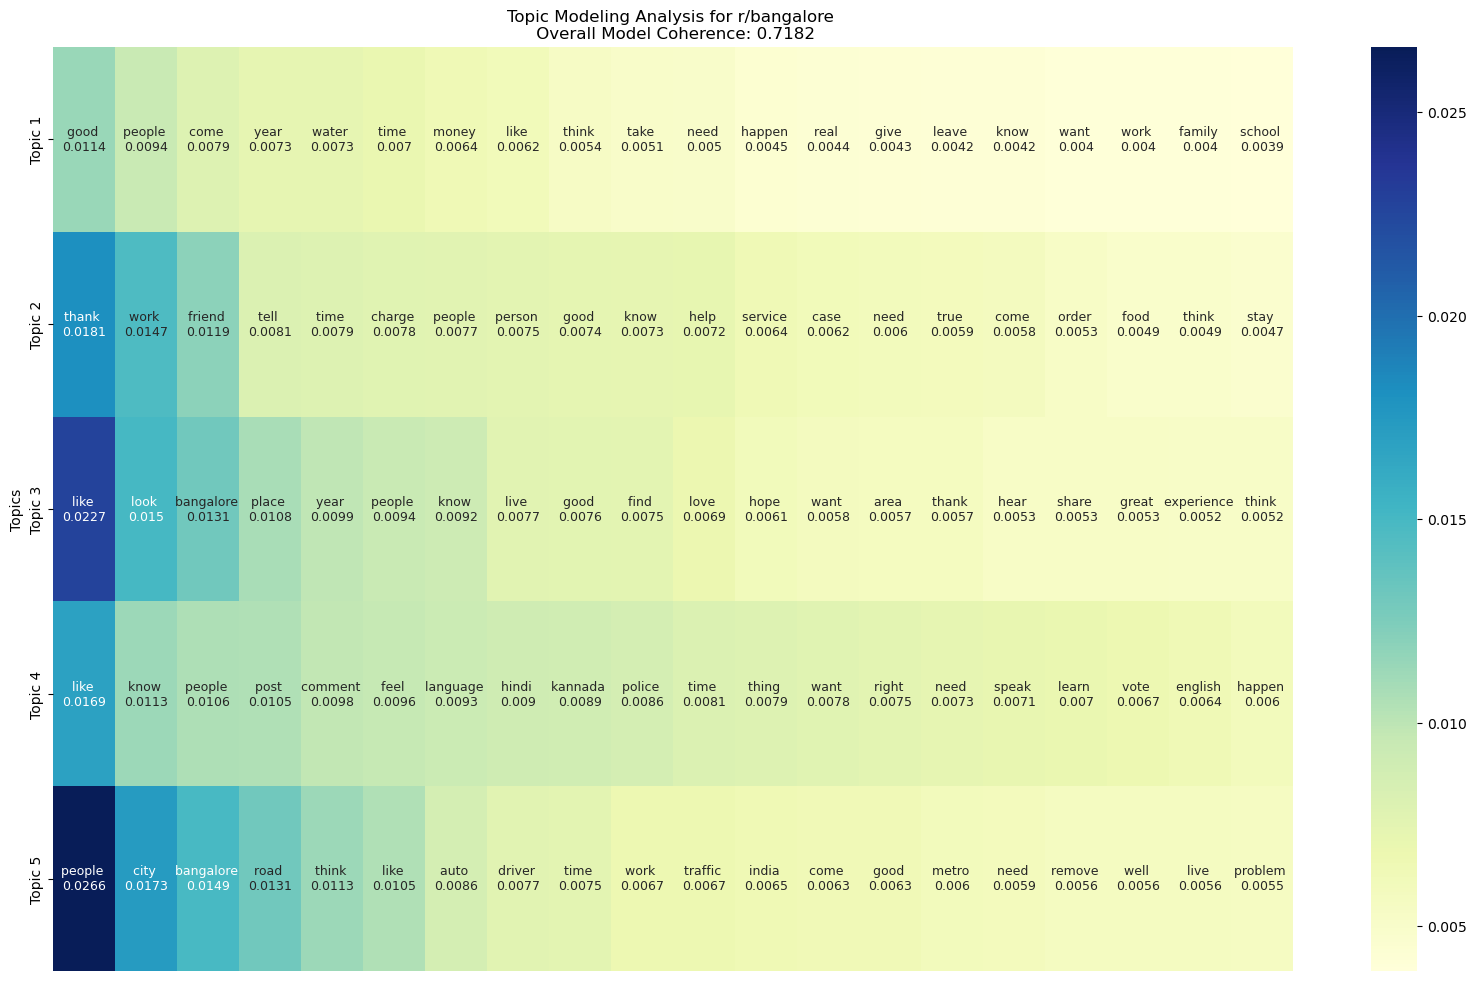

In [51]:
ban_top5_topics = topic_coherence(ban_df["processed_text_bigrams"], 5, return_coh = False)
plt = plot_topic_word_heatmap(ban_top5_topics, "bangalore", (20,12), 5)
plt.savefig("images/bangalore_top5_topics_words_per_topic.png")

#### Version 2 - Topic Modeling for three Tier 1 cities in USA - NYC, Chicago, Boston

In [2]:
nyc_df = pd.read_pickle("data/nyc_df.pkl")
# chi_df = pd.read_pickle("data/chi_df.pkl")
# bos_df = pd.read_pickle("data/bos_df.pkl")

In [43]:
top_coh_us = pd.DataFrame(index = range(2,11,1))
top_coh_us["nyc"] = optimal_topics(nyc_df)
top_coh_us["chicago"] = optimal_topics(chi_df)
top_coh_us["boston"] = optimal_topics(bos_df)
top_coh_us

,nyc,chicago,boston
2,0.73,0.71,0.71
3,0.67,0.71,0.71
4,0.66,0.67,0.68
5,0.61,0.65,0.68
6,0.62,0.64,0.65
7,0.60,0.65,0.63
8,0.62,0.58,0.63
9,0.58,0.55,0.61
10,0.60,0.57,0.61


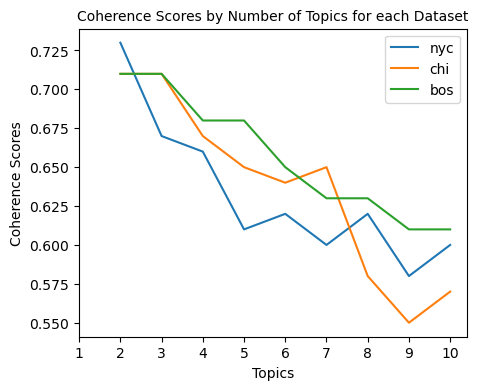

In [28]:
os.chdir('/home/prabhur/reddit_project/')
plt = plot_coherence(top_coh_us)
plt.savefig("images/TopvsCoherence_US.jpg")

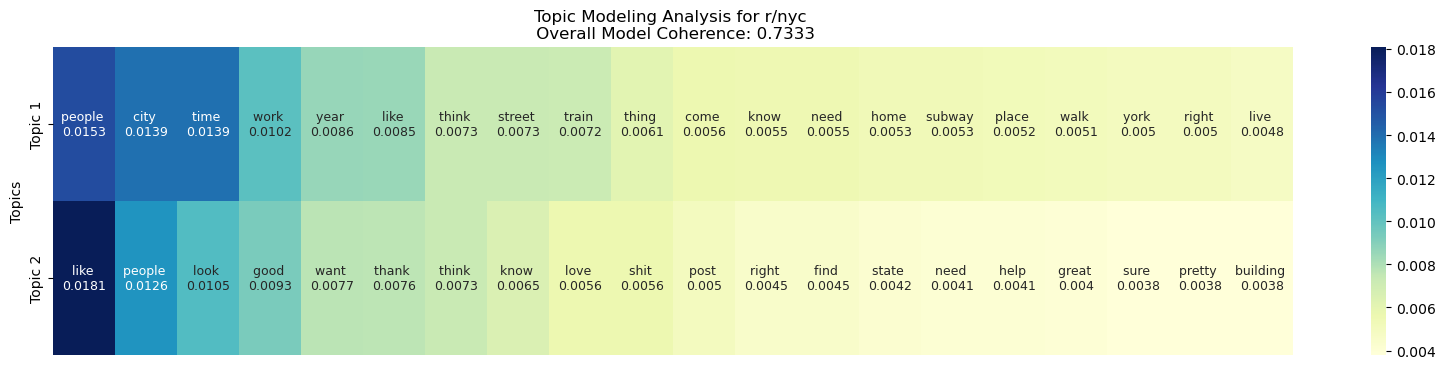

In [52]:
nyc_two_topics = topic_coherence(nyc_df["processed_text_bigrams"], 2, return_coh = False)
plt = plot_topic_word_heatmap(nyc_two_topics, "nyc", (20,4))
plt.savefig("images/nyc_top2_topics_words_per_topic.png")

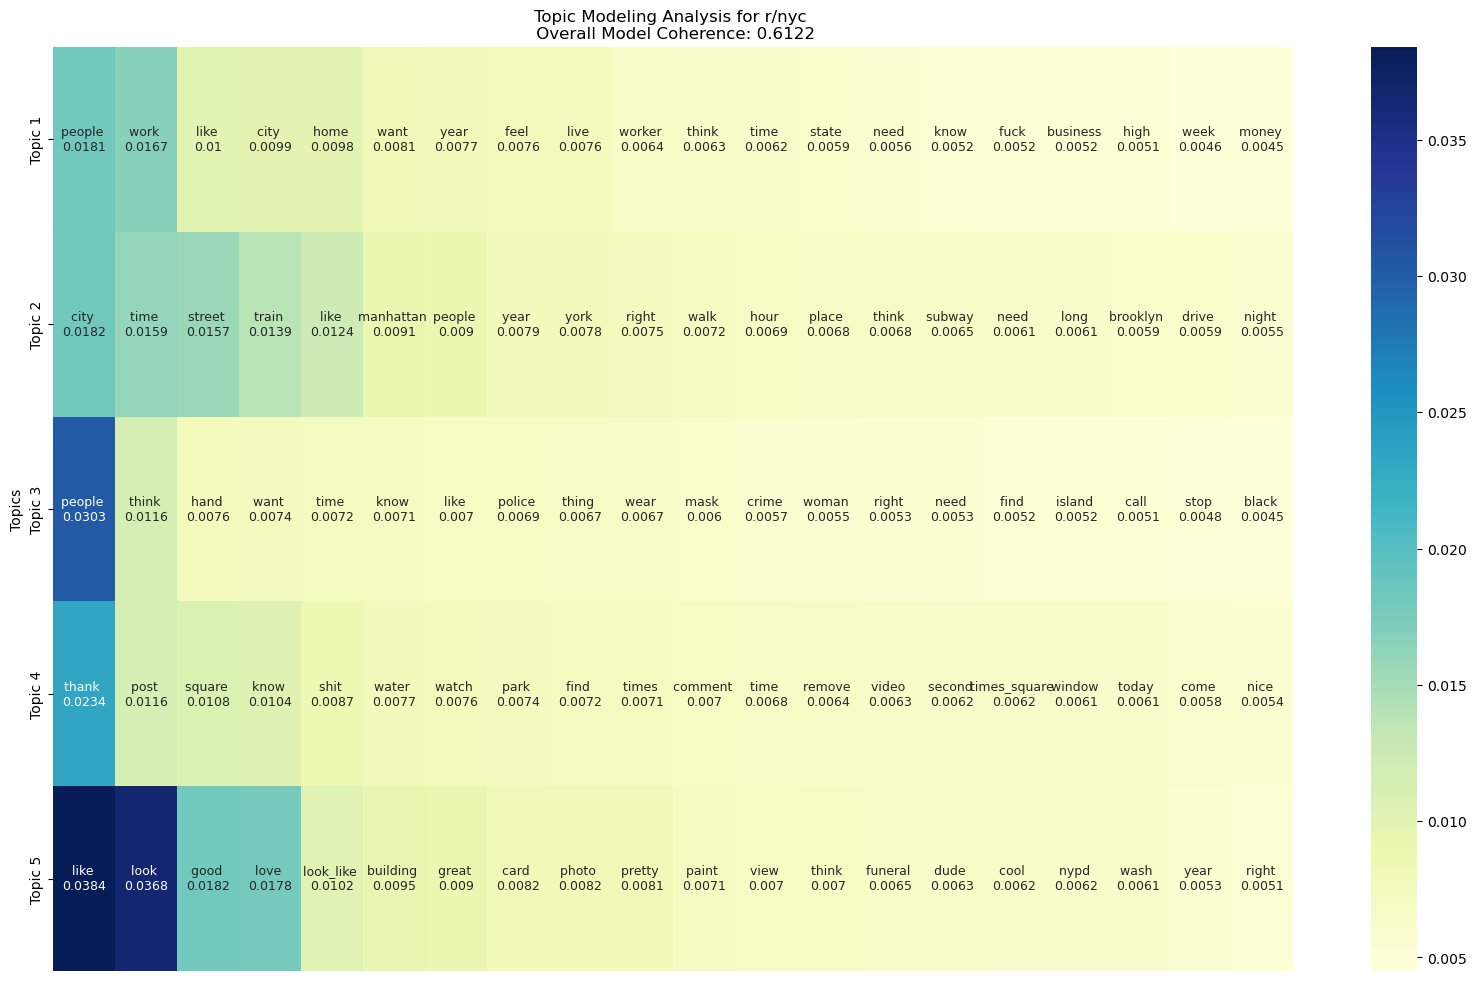

In [53]:
nyc_top5_topics = topic_coherence(nyc_df["processed_text_bigrams"], 5, return_coh = False)
plt = plot_topic_word_heatmap(nyc_top5_topics, "nyc", (20,12), 5)
plt.savefig("images/nyc_top5_topics_words_per_topic.png")

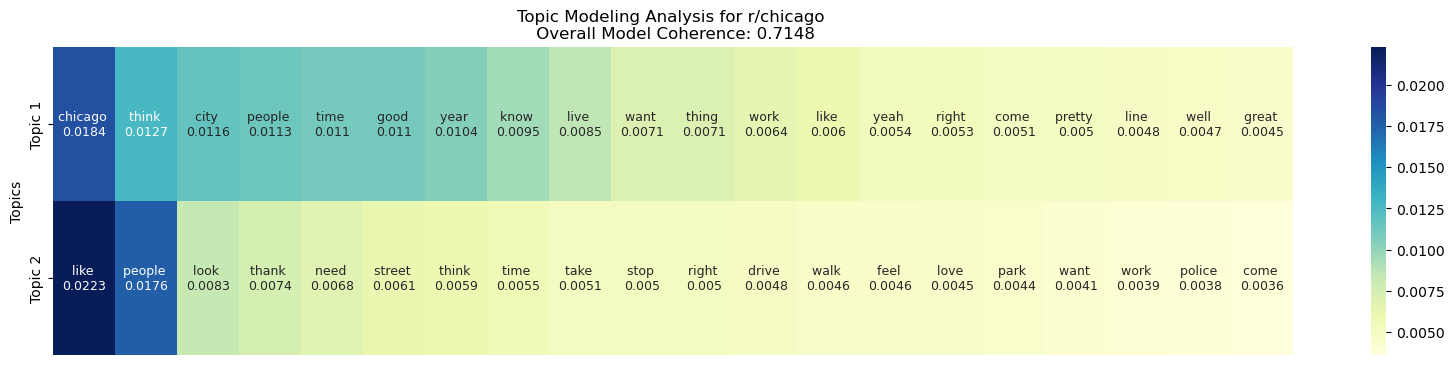

In [54]:
chi_two_topics = topic_coherence(chi_df["processed_text_bigrams"], 2, return_coh = False)
plt = plot_topic_word_heatmap(chi_two_topics, "chicago", (20,4))
plt.savefig("images/chicago_top2_topics_words_per_topic.png")

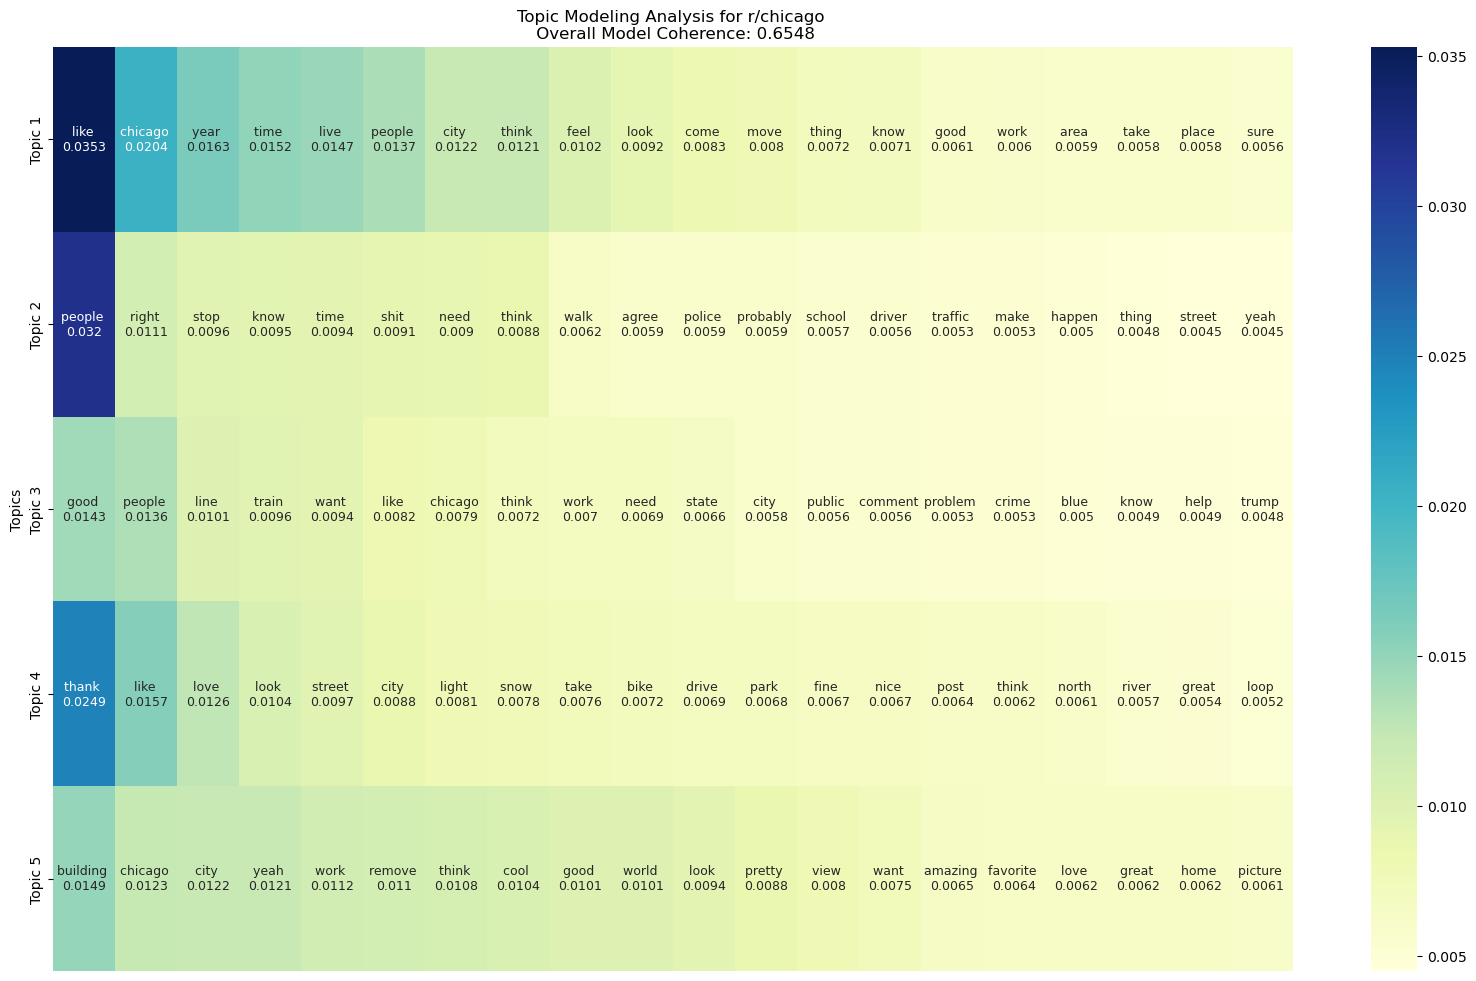

In [55]:
chi_top5_topics = topic_coherence(chi_df["processed_text_bigrams"], 5, return_coh = False)
plt = plot_topic_word_heatmap(chi_top5_topics, "chicago", (20,12), 5)
plt.savefig("images/chicago_top5_topics_words_per_topic.png")

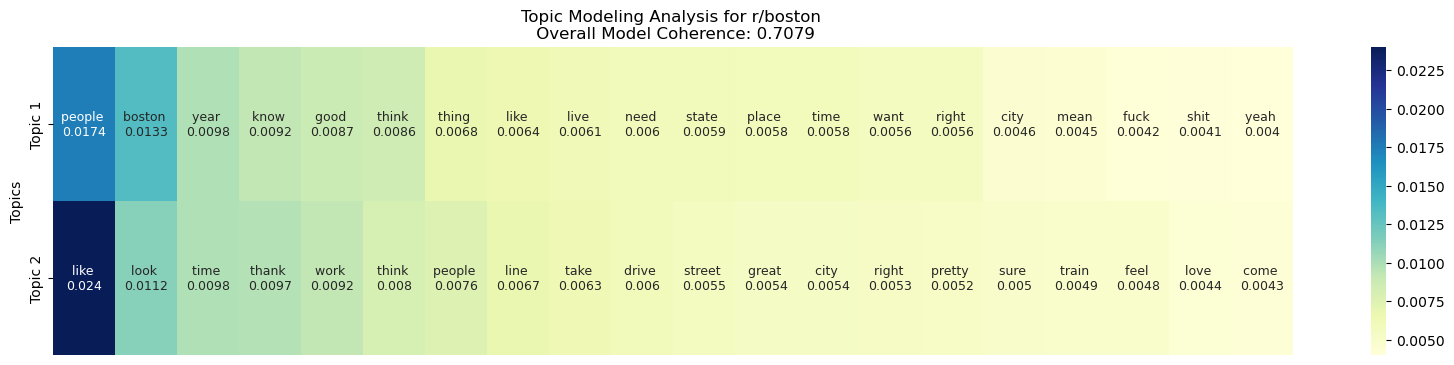

In [56]:
bos_two_topics = topic_coherence(bos_df["processed_text_bigrams"], 2, return_coh = False)
plt = plot_topic_word_heatmap(bos_two_topics, "boston", (20,4))
plt.savefig("images/boston_top2_topics_words_per_topic.png")

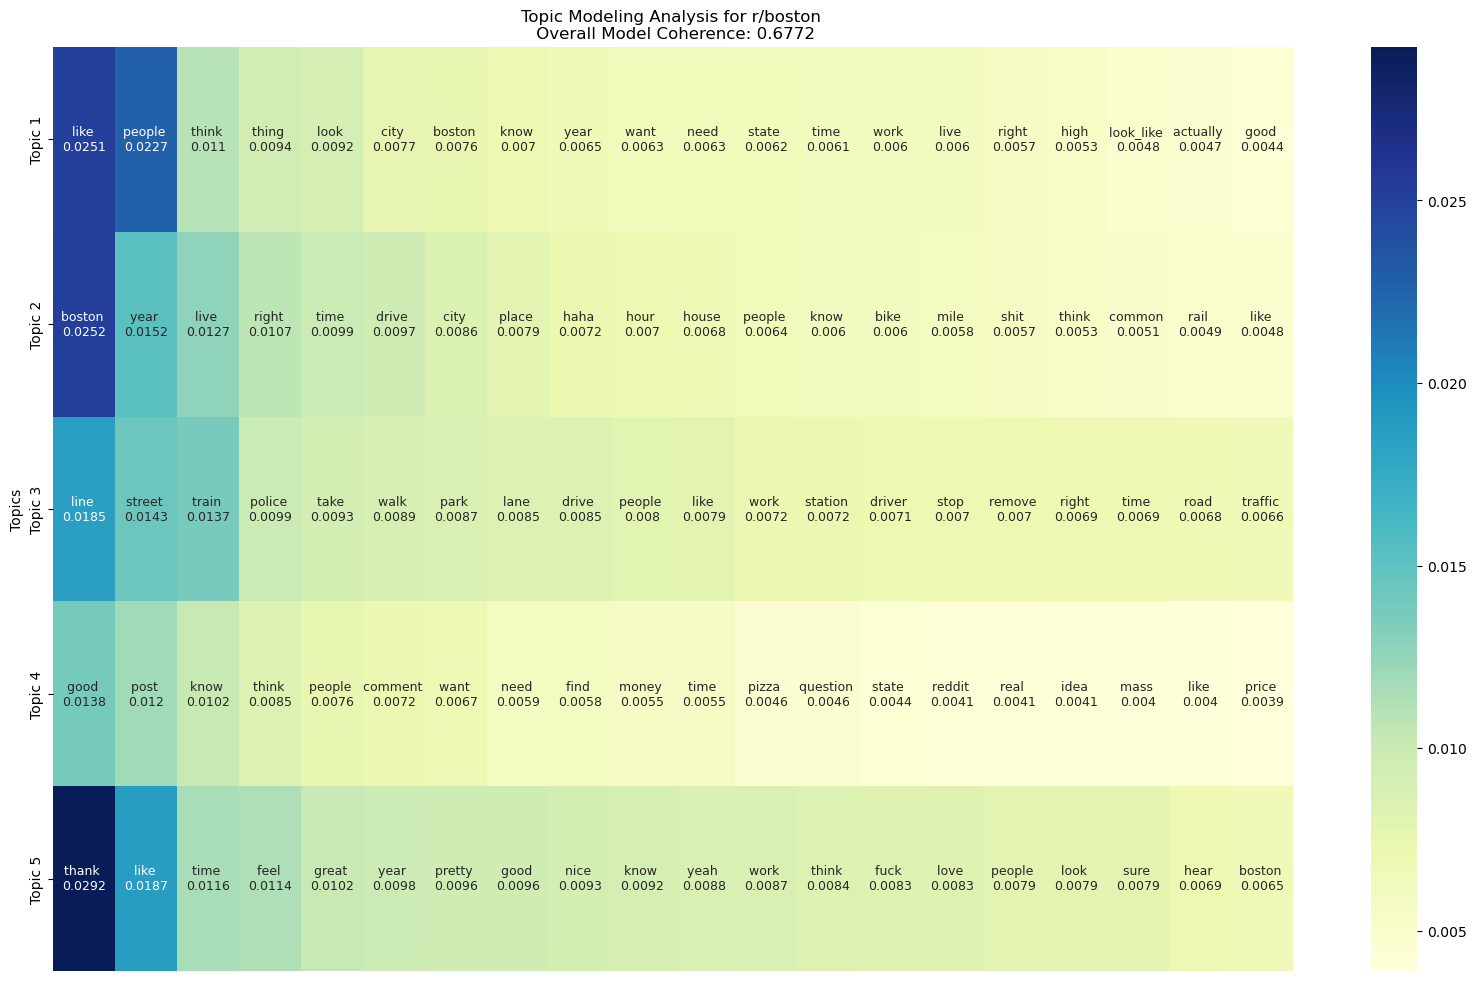

In [57]:
bos_top5_topics = topic_coherence(bos_df["processed_text_bigrams"], 5, return_coh = False)
plot_topic_word_heatmap(bos_top5_topics, "boston", (20,12), 5)
plt.savefig("images/boston_top5_topics_words_per_topic.png")